In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, product
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import argparse
import random
import scipy.sparse as sparse

In [2]:
#data_dir = '../../DATA/ihart.ms2/genotypes'
#ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'
#phase_dir = '../../PhasingFamilies/phased_ihart.ms2_quads'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/ihart.ms2_quads_identicals.txt'

data_dirs = [#'../../DATA/ihart.ms2/genotypes',
             '../../DATA/mssng/genotypes',
             #'../../DATA/ssc.hg38/genotypes/phase2'
]
ped_files = [#'../../DATA/ihart.ms2/ihart.ped.quads.ped',
             '../../DATA/mssng/mssng.ped.quads.ped',
             #'../../DATA/ssc.hg38/ssc.ped'
]
phase_dirs = [#'../../PhasingFamilies/phased_ihart.ms2_quads',
              '../../PhasingFamilies/phased_mssng_quads',
              #'../../PhasingFamilies/phased_ssc.hg38'
]
identicals_files = [#'../../PhasingFamilies/sibpair_similarity/ihart.ms2_quads_identicals.txt',
                    '../../PhasingFamilies/sibpair_similarity/mssng_quads_identicals.txt',
                    #'../../PhasingFamilies/sibpair_similarity/ssc_identicals.txt'
]


#data_dir = '../../DATA/mssng/genotypes'
#ped_file = '../../DATA/mssng/mssng.ped.quads.ped'
#phase_dir = '../../PhasingFamilies/phased_mssng_quads'
#identicals_file = '../../PhasingFamilies/sibpair_similarity/mssng_quads_identicals.txt'


start_pos, end_pos = 125880000, 125930000
chrom = '10'

In [3]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_sex[pieces[3]] = '2'
			sample_to_sex[pieces[2]] = '1'
			sample_to_affected[pieces[1]] = pieces[5]
			parents_to_children[(pieces[0], pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children


Sibpair = namedtuple('Sibpair', ['family', 'sibling1', 'sibling2', 'mom', 'dad', 'phase_dir', 
                                 'num_affected', 'num_males', 
                                 'sibling1_aff', 'sibling2_aff', 'sibling1_male', 'sibling2_male'])
def pull_sibpairs(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file):

	# pull identicals
	leave_out = set()
	with open(identicals_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			for sibling1, sibling2 in combinations(pieces, 2):
				leave_out.add((sibling1, sibling2))
				leave_out.add((sibling2, sibling1))


	# pull sibpairs with phase data
	sibpair_has_phase_data = set()
	family_to_inds = dict()
	for filename in listdir(phase_dir):
		if filename.endswith('.phased.txt'):
			family_key = filename[:-11]
			try:
				with open('%s/%s' % (phase_dir, filename), 'r')  as f:
					header = next(f).strip().split('\t')
					individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
					family_to_inds[family_key] = individuals
					for sibling1, sibling2 in combinations(individuals[2:], 2):
						if (sibling1, sibling2) not in leave_out:
							sibpair_has_phase_data.add((sibling1, sibling2))
							sibpair_has_phase_data.add((sibling2, sibling1))
			except StopIteration:
				pass



	def form_sibpair(family, sibling1, sibling2, mom, dad):
		return Sibpair(family, sibling1, sibling2, mom, dad,
			phase_dir,
			int(sample_to_affected[sibling1]=='2')+int(sample_to_affected[sibling2]=='2'),
			int(sample_to_sex[sibling1]=='1')+int(sample_to_sex[sibling2]=='1'),
			sample_to_affected[sibling1]=='2', sample_to_affected[sibling2]=='2',
			sample_to_sex[sibling1]=='1', sample_to_sex[sibling2]=='1')
	# pull sibpairs from families
	sibpairs = []
	for (family, mom, dad), children in parents_to_children.items():
		for sibling1, sibling2 in combinations([x for x in children if x in sample_to_affected], 2):
			if (sibling1, sibling2) in sibpair_has_phase_data:
				sibpairs.append(form_sibpair(family, sibling1, sibling2, mom, dad))
	sibpairs = sorted(sibpairs)

	for i in range(len(sibpairs)-1):
		if sibpairs[i] == sibpairs[i+1]:
			print(sibpairs[i])

	assert len(sibpairs) == len(set(sibpairs)) # should have no duplicates
	return sibpairs, family_to_inds




In [4]:
Trio = namedtuple('Sibpair', ['family', 'child', 'mom', 'dad', 'phase_dir', 
                                 'is_affected', 'is_male'])
def pull_trios(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file):

	# pull identicals
	leave_out = set()
	with open(identicals_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			leave_out.update(pieces)


	# pull sibpairs with phase data
	sibpair_has_phase_data = set()
	family_to_inds = dict()
	for filename in listdir(phase_dir):
		if filename.endswith('.phased.txt'):
			family_key = filename[:-11]
			try:
				with open('%s/%s' % (phase_dir, filename), 'r')  as f:
					header = next(f).strip().split('\t')
					individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
					family_to_inds[family_key] = individuals
					for child in individuals[2:]:
						if child not in leave_out:
							sibpair_has_phase_data.add(child)
			except StopIteration:
				pass



	def form_sibpair(family, child, mom, dad):
		return Trio(family, child, mom, dad,
			phase_dir,
			sample_to_affected[child]=='2',
			sample_to_sex[child]=='1')
	# pull sibpairs from families
	trios = []
	for (family, mom, dad), children in parents_to_children.items():
		for child in [x for x in children if x in sample_to_affected]:
			if child in sibpair_has_phase_data:
				trios.append(form_sibpair(family, child, mom, dad))
	trios = sorted(trios)

	for i in range(len(trios)-1):
		if trios[i] == trios[i+1]:
			print(trios[i])

	assert len(trios) == len(set(trios)) # should have no duplicates
	return trios, family_to_inds



In [5]:
def pull_counts(trios, sibpairs, data_dir):
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
    coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
    sample_file = '%s/samples.json' % data_dir

    # read samples
    with open(sample_file, 'r') as f:
        samples = json.load(f)
        sample_id_to_index = dict([(x, i) for i, x in enumerate(samples)])

    trios = [x for x in trios if x.mom in sample_id_to_index and x.dad in sample_id_to_index and x.child in sample_id_to_index]
    sibpairs = [x for x in sibpairs if x.mom in sample_id_to_index and x.dad in sample_id_to_index and x.sibling1 in sample_id_to_index and x.sibling2 in sample_id_to_index]
    print(len(trios), len(sibpairs))
    sp_indices = np.array([(sample_id_to_index[sp.mom], sample_id_to_index[sp.dad], 
                         sample_id_to_index[sp.sibling1], sample_id_to_index[sp.sibling2]) for sp in sibpairs])
    trio_indices = np.array([(sample_id_to_index[sp.mom], sample_id_to_index[sp.dad], 
                         sample_id_to_index[sp.child]) for sp in trios])

    sp_gens, trio_gens, snp_positions = [], [], []
    total_pos = 0
    for gen_file, coord_file in zip(gen_files, coord_files):
        coords = np.load('%s/%s' % (data_dir, coord_file))

        if coords.shape[0]>0:
            poss = coords[:, 1]
            is_snp = coords[:, 2]==1
            is_pass = coords[:, 3]==1

            in_interval = (coords[:, 1]>=start_pos) & (coords[:, 1]<=end_pos) & is_snp & is_pass
            if np.sum(is_snp & is_pass & in_interval)>0:
                gen = sparse.load_npz('%s/%s' % (data_dir, gen_file))[:, in_interval].A
                sp_gens.append(gen[sp_indices, :])
                trio_gens.append(gen[trio_indices, :])
                snp_positions.append(poss[in_interval])

    sp_gens = np.hstack(sp_gens)
    trio_gens = np.hstack(trio_gens)
    snp_positions = np.hstack(snp_positions)
    print(sp_gens.shape, trio_gens.shape, snp_positions.shape)
    
    fam_has_variant = np.any(sp_gens!=0, axis=1)
    print(fam_has_variant.shape)
    
    num_affected = np.array([sp.num_affected for sp in sibpairs])
    sibpair_genotypes = [x for x in product(*[[0, 1, 2]]*4) if x[3]>=x[2] and x[1]>=x[0]]
    counts = np.zeros((len(sibpair_genotypes), 3))
    counts_pos = np.zeros((len(sibpair_genotypes), 3, len(snp_positions)))
    for i, sibpair_gen in enumerate(sibpair_genotypes):
        for na in [0, 1, 2]:
            counts[i, na] = np.sum((((sp_gens[num_affected==na, 0, :]==sibpair_gen[0]) & (sp_gens[num_affected==na, 1, :]==sibpair_gen[1])) | ((sp_gens[num_affected==na, 0, :]==sibpair_gen[1]) & (sp_gens[num_affected==na, 1, :]==sibpair_gen[0]))) & \
                                   (((sp_gens[num_affected==na, 2, :]==sibpair_gen[2]) & (sp_gens[num_affected==na, 3, :]==sibpair_gen[3])) | ((sp_gens[num_affected==na, 2, :]==sibpair_gen[3]) & (sp_gens[num_affected==na, 3, :]==sibpair_gen[2]))))
            
            counts_pos[i, na, :] = np.sum((((sp_gens[num_affected==na, 0, :]==sibpair_gen[0]) & (sp_gens[num_affected==na, 1, :]==sibpair_gen[1])) | ((sp_gens[num_affected==na, 0, :]==sibpair_gen[1]) & (sp_gens[num_affected==na, 1, :]==sibpair_gen[0]))) & \
                                   (((sp_gens[num_affected==na, 2, :]==sibpair_gen[2]) & (sp_gens[num_affected==na, 3, :]==sibpair_gen[3])) | ((sp_gens[num_affected==na, 2, :]==sibpair_gen[3]) & (sp_gens[num_affected==na, 3, :]==sibpair_gen[2]))), axis=0)
            
            
    is_aff = np.array([sp.is_affected for sp in trios])
    is_male = np.array([sp.is_male for sp in trios])
    trio_genotypes = [x for x in product(*[[0, 1, 2]]*3) if x[1]>=x[0]]
    print(len(trio_genotypes))
    trio_counts = np.zeros((len(trio_genotypes), 2))
    trio_counts_male = np.zeros((len(trio_genotypes), 2))
    trio_counts_pos = np.zeros((len(trio_genotypes), 2, len(snp_positions)))
    for i, trio_gen in enumerate(trio_genotypes):

        trio_counts[i, 1] = np.sum((((trio_gens[is_aff, 0]==trio_gen[0]) & (trio_gens[is_aff, 1]==trio_gen[1])) | ((trio_gens[is_aff, 0]==trio_gen[1]) & (trio_gens[is_aff, 1]==trio_gen[0]))) & \
                                     (trio_gens[is_aff, 2]==trio_gen[2]))
        trio_counts[i, 0] = np.sum((((trio_gens[~is_aff, 0]==trio_gen[0]) & (trio_gens[~is_aff, 1]==trio_gen[1])) | ((trio_gens[~is_aff, 0]==trio_gen[1]) & (trio_gens[~is_aff, 1]==trio_gen[0]))) & \
                              (trio_gens[~is_aff, 2]==trio_gen[2]))

        trio_counts_male[i, 1] = np.sum((((trio_gens[is_male, 0]==trio_gen[0]) & (trio_gens[is_male, 1]==trio_gen[1])) | ((trio_gens[is_male, 0]==trio_gen[1]) & (trio_gens[is_male, 1]==trio_gen[0]))) & \
                              (trio_gens[is_male, 2]==trio_gen[2]))
        trio_counts_male[i, 0] = np.sum((((trio_gens[~is_male, 0]==trio_gen[0]) & (trio_gens[~is_male, 1]==trio_gen[1])) | ((trio_gens[~is_male, 0]==trio_gen[1]) & (trio_gens[~is_male, 1]==trio_gen[0]))) & \
                              (trio_gens[~is_male, 2]==trio_gen[2]))
        
        trio_counts_pos[i, 1, :] += np.sum((((trio_gens[is_aff, 0]==trio_gen[0]) & (trio_gens[is_aff, 1]==trio_gen[1])) | ((trio_gens[is_aff, 0]==trio_gen[1]) & (trio_gens[is_aff, 1]==trio_gen[0]))) & \
                              (trio_gens[is_aff, 2]==trio_gen[2]), axis=0)
        trio_counts_pos[i, 0, :] += np.sum((((trio_gens[~is_aff, 0]==trio_gen[0]) & (trio_gens[~is_aff, 1]==trio_gen[1])) | ((trio_gens[~is_aff, 0]==trio_gen[1]) & (trio_gens[~is_aff, 1]==trio_gen[0]))) & \
                              (trio_gens[~is_aff, 2]==trio_gen[2]), axis=0)
        
    return sibpair_genotypes, counts, trio_genotypes, trio_counts, trio_counts_male, trio_counts_pos, counts_pos, snp_positions




In [6]:
all_counts, all_trio_counts, all_trio_counts_male = [], [], []
for ped_file, phase_dir, data_dir, identicals_file in zip(ped_files, phase_dirs, data_dirs, identicals_files):
    sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped(ped_file)

    sibpairs, family_to_inds = pull_sibpairs(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file)
    trios, family_to_inds = pull_trios(phase_dir, sample_to_affected, sample_to_sex, parents_to_children, identicals_file)

    sibpair_genotypes, counts, trio_genotypes, trio_counts, trio_counts_male, trio_counts_pos, counts_pos, snp_positions = pull_counts(trios, sibpairs, data_dir)
    all_counts.append(counts)
    all_trio_counts.append(trio_counts)
    all_trio_counts_male.append(trio_counts_male)
    

1454 737
(737, 4, 1989) (1454, 3, 1989) (1989,)
(737, 1989)
18


In [7]:
print(trio_counts_pos.shape, snp_positions.shape)

(18, 2, 1989) (1989,)


In [8]:

        
for i, sp_gen in enumerate(sibpair_genotypes):
    try:
        chi = stats.chi2_contingency([[counts[i, 0], counts[i, 1], counts[i, 2]], 
                                      [np.sum(counts[:, 0])-counts[i, 0],
                                       np.sum(counts[:, 1])-counts[i, 1],
                                       np.sum(counts[:, 2])-counts[i, 2]]])
        if chi[1]*len(sibpair_genotypes) < 0.05:
            print(sp_gen, 
                  counts[i, 0]/np.sum(counts[:, 0]),
                  counts[i, 1]/np.sum(counts[:, 1]),
                  counts[i, 2]/np.sum(counts[:, 2]),
                  chi[1]*len(sibpair_genotypes))
    except:
        pass
    
print(sibpair_genotypes)

(0, 1, 0, 0) 0.0023357769153370704 0.0023082614056720097 0.0031468793270908978 7.056574660761814e-17
(0, 1, 0, 1) 0.003332973983038666 0.005191122071516646 0.0045895505467491915 6.392687914766322e-14
(0, 2, 0, 1) 3.593502946672416e-05 2.9593094944512948e-05 4.218336899585654e-06 0.004962135142967307
(0, 2, 1, 1) 0.0028927698720712953 0.0019408138101109742 0.002083858428395313 1.755643294037882e-07
(1, 1, 0, 0) 0.000880408221934742 0.0003378545006165228 0.000285792324946928 2.4213770054642498e-21
(1, 1, 0, 1) 0.002236955584303579 0.0015166461159062884 0.001517546699625939 1.533719309221102e-06
(1, 1, 0, 2) 0.0007276843467011643 0.0003255240443896424 0.0005009275068257964 6.336015837866594e-07
(1, 1, 1, 1) 0.009037659910881127 0.00924537607891492 0.010017495552291032 0.0002760012189879733
(1, 1, 1, 2) 0.0013924823918355614 0.0011467324290998766 0.0009185428598847762 6.075406173028687e-06
(1, 1, 2, 2) 5.3902544200086246e-05 0.0003304562268803946 0.000285792324946928 0.0002122936054784523


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


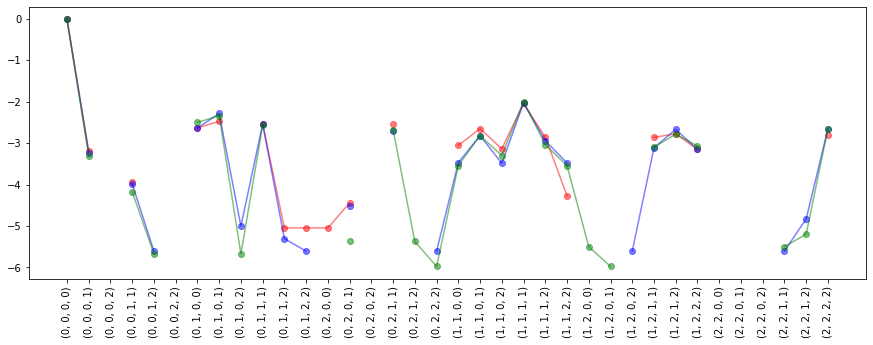

In [9]:
plt.figure(figsize=(15, 5))
for counts in all_counts:
    plt.plot(np.log10(counts[:, 0]/np.sum(counts[:, 0])), marker='o', alpha=0.5, color='red')
    plt.plot(np.log10(counts[:, 1]/np.sum(counts[:, 1])), marker='o', alpha=0.5, color='blue')
    plt.plot(np.log10(counts[:, 2]/np.sum(counts[:, 2])), marker='o', alpha=0.5, color='green')
#plt.plot(np.log10(np.sum(counts[has_data, :], axis=1)/np.sum(counts[has_data, :])), marker='o', alpha=0.5, color='black')
plt.xticks(np.arange(len(sibpair_genotypes)), [str(x) for x in sibpair_genotypes], rotation=90)
plt.show()

In [10]:


    
for i, trio_gen in enumerate(trio_genotypes):
    try:
        chi = stats.chi2_contingency([[trio_counts[i, 0], trio_counts[i, 1]], 
                                            [np.sum(trio_counts[:, 0])-trio_counts[i, 0],
                                             np.sum(trio_counts[:, 1])-trio_counts[i, 1]]])
        if chi[1]*len(trio_genotypes) < 0.05:
            print(trio_gen, 
                  trio_counts[i, 0]/np.sum(trio_counts[:, 0]),
                  trio_counts[i, 1]/np.sum(trio_counts[:, 1]),
                  chi[1]*len(trio_genotypes))
    except:
        pass
        
#print(sibpair_genotypes)

(0, 0, 1) 0.0004361821012515561 0.0003076200944871032 1.880434207687167e-05
(0, 1, 0) 0.004656323526134312 0.005370534149587342 6.916243628202052e-11
(0, 1, 2) 1.2735243832162222e-05 2.209914471890109e-06 0.030003798010545975
(0, 2, 0) 2.3878582185304164e-05 3.977846049402196e-06 7.774282169422728e-05
(0, 2, 1) 0.0022907519843101795 0.00199069095627861 6.603404681121399e-05
(1, 1, 0) 0.0018673051268907857 0.0012455077963572654 1.7507160029755422e-30
(1, 1, 1) 0.010619601450544273 0.011227691465884888 0.0008692686242125913
(1, 2, 1) 0.00200580090356555 0.001643292401297485 1.7554255843935806e-08
(2, 2, 2) 0.001994657565212408 0.002235991462658412 0.005510307631273932


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


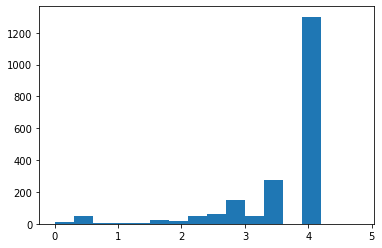

In [11]:
var = np.zeros((len(snp_positions),))
novar = np.zeros((len(snp_positions),))
for i, tgen in enumerate(trio_genotypes):
    m = tgen[0]+tgen[1]
    var += m*np.sum(trio_counts_pos[i, :, :], axis=0)
    novar += (4-m)*np.sum(trio_counts_pos[i, :, :], axis=0)
af = var/(var+novar)
plt.hist(np.clip(-np.log10(af), None, 4), bins=np.arange(0, 5, 0.3))
plt.show()

In [12]:
plt.figure(figsize=(15, 15))

#np.set_printoptions(precision=4)
#np.set_printoptions(suppress=True)
#pvalues_quad = np.ones((6, len(snp_positions)))
#for j, parent_gen in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[1]>=x[0]]):
    indices = np.array([(x[0]==parent_gen[0] and x[1]==parent_gen[1]) or (x[0]==parent_gen[1] and x[1]==parent_gen[0]) for x in sibpair_genotypes])
    c = np.array([counts[indices, 0], counts[indices, 1]])
    print(parent_gen)
    print((c.T/np.sum(c, axis=1)).T)
    print(stats.chi2_contingency(c[np.sum(c, axis=1)>0, :][:, np.sum(c, axis=0)>0])[1])
    
    plt.subplot(6, 1, j+1)
    for i in np.where(indices)[0]:
        plt.scatter(snp_positions, trio_counts_pos[i, 0, :]/np.sum(trio_counts_pos[indices, 0, :], axis=0), label=trio_genotypes[i])
        
    for k in range(snp_positions.shape[0]):
        try:
            c = np.array([trio_counts_pos[indices, 0, k], trio_counts_pos[indices, 1, k]])
            pvalues[j, k] = stats.chi2_contingency(c[np.sum(c, axis=1)>0, :][:, np.sum(c, axis=0)>0])[1]
        except:
            pass
    plt.legend()
    

IndentationError: unexpected indent (<ipython-input-12-799329422d73>, line 7)

In [ ]:
plt.figure(figsize=(15, 15))

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
pvalues = np.ones((6, len(snp_positions)))
for j, parent_gen in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[1]>=x[0]]):
    indices = np.array([(x[0]==parent_gen[0] and x[1]==parent_gen[1]) or (x[0]==parent_gen[1] and x[1]==parent_gen[0]) for x in trio_genotypes])
    c = np.array([trio_counts[indices, 0], trio_counts[indices, 1]])
    print(parent_gen)
    print((c.T/np.sum(c, axis=1)).T)
    print(stats.chi2_contingency(c[np.sum(c, axis=1)>0, :][:, np.sum(c, axis=0)>0])[1])
    
    plt.subplot(6, 1, j+1)
    for i in np.where(indices)[0]:
        plt.scatter(snp_positions, trio_counts_pos[i, 0, :]/np.sum(trio_counts_pos[indices, 0, :], axis=0), label=trio_genotypes[i])
        
    for k in range(snp_positions.shape[0]):
        try:
            c = np.array([trio_counts_pos[indices, 0, k], trio_counts_pos[indices, 1, k]])
            pvalues[j, k] = stats.chi2_contingency(c[np.sum(c, axis=1)>0, :][:, np.sum(c, axis=0)>0])[1]
        except:
            pass
    plt.legend()
    

In [ ]:
plt.figure(figsize=(15, 5))
for i, pgen in enumerate([x for x in product(*[[0, 1, 2]]*2) if x[1]>=x[0]]):
    plt.scatter(snp_positions, -np.log10(pvalues[i, :]), label=str(pgen), alpha=0.5)

bon_cutoff = 0.05/(pvalues.shape[0]*pvalues.shape[1])
plt.axhline(-np.log10(bon_cutoff), color='black', linestyle='--')
plt.legend()
plt.show()

In [ ]:
print(trio_genotypes)

In [ ]:
indices = np.array([x[0]==0 and x[1]==0 for x in trio_genotypes])

aut_frac = trio_counts_pos[trio_genotypes.index((0, 0, 1)), 1, :]/np.sum(trio_counts_pos[indices, 1, :], axis=0)
nt_frac = trio_counts_pos[trio_genotypes.index((0, 0, 1)), 0, :]/np.sum(trio_counts_pos[indices, 0, :], axis=0)

plt.figure(figsize=(15, 5))
#plt.subplot(2, 1, 1)
plt.scatter(snp_positions[aut_frac>nt_frac], -np.log10(pvalues[0, aut_frac>nt_frac]), label=str(pgen), alpha=0.5)
plt.scatter(snp_positions[aut_frac<nt_frac], np.log10(pvalues[0, aut_frac<nt_frac]), label=str(pgen), alpha=0.5)
plt.axhline(-np.log10(bon_cutoff), color='black', linestyle='--')
plt.axhline(np.log10(bon_cutoff), color='black', linestyle='--')

#plt.subplot(2, 1, 2)
#plt.plot(aut_frac, alpha=0.5)
#plt.plot(nt_frac, alpha=0.5)
plt.show()

for j in np.where(pvalues[0, :]<bon_cutoff)[0]:
    print(snp_positions[j], -np.log10(pvalues[:, j]))
    indices = np.array([x[0]==0 and x[1]==0 for x in trio_genotypes])
    print((0, 0))
    print(trio_counts_pos[indices, :, j]/np.sum(trio_counts_pos[indices, :, j], axis=0))
    indices = np.array([(x[0]==0 and x[1]==1) or (x[0]==1 and x[1]==0) for x in trio_genotypes])
    print((0, 1))
    print(trio_counts_pos[indices, :, j]/np.sum(trio_counts_pos[indices, :, j], axis=0))
    indices = np.array([x[0]==1 and x[1]==1 for x in trio_genotypes])
    print((1, 1))
    print(trio_counts_pos[indices, :, j]/np.sum(trio_counts_pos[indices, :, j], axis=0))


In [ ]:
indices = np.array([(x[0]==0 and x[1]==1) or (x[0]==1 and x[1]==0) for x in trio_genotypes])

aut_frac = trio_counts_pos[trio_genotypes.index((0, 1, 1)), 1, :]/np.sum(trio_counts_pos[indices, 1, :], axis=0)
nt_frac = trio_counts_pos[trio_genotypes.index((0, 1, 1)), 0, :]/np.sum(trio_counts_pos[indices, 0, :], axis=0)

plt.figure(figsize=(15, 5))
#plt.subplot(2, 1, 1)
plt.scatter(snp_positions[aut_frac>nt_frac], -np.log10(pvalues[0, aut_frac>nt_frac]), label=str(pgen), alpha=0.5)
plt.scatter(snp_positions[aut_frac<nt_frac], np.log10(pvalues[0, aut_frac<nt_frac]), label=str(pgen), alpha=0.5)
plt.axhline(-np.log10(bon_cutoff), color='black', linestyle='--')
plt.axhline(np.log10(bon_cutoff), color='black', linestyle='--')

#plt.subplot(2, 1, 2)
#plt.plot(aut_frac, alpha=0.5)
#plt.plot(nt_frac, alpha=0.5)
plt.show()

for j in np.where(pvalues[0, :]<bon_cutoff)[0]:
    print(snp_positions[j], -np.log10(pvalues[:, j]))
    indices = np.array([x[0]==0 and x[1]==0 for x in trio_genotypes])
    print((0, 0))
    print(trio_counts_pos[indices, :, j]/np.sum(trio_counts_pos[indices, :, j], axis=0))
    indices = np.array([(x[0]==0 and x[1]==1) or (x[0]==1 and x[1]==0) for x in trio_genotypes])
    print((0, 1))
    print(trio_counts_pos[indices, :, j]/np.sum(trio_counts_pos[indices, :, j], axis=0))
    indices = np.array([x[0]==1 and x[1]==1 for x in trio_genotypes])
    print((1, 1))
    print(trio_counts_pos[indices, :, j]/np.sum(trio_counts_pos[indices, :, j], axis=0))


In [ ]:
plt.hist(-np.log10(pvalues[0, :]), log=True, alpha=0.5, bins=np.arange(0, 10, 0.1))
#plt.plot(np.arange(0, 10, 0.1), )
plt.show()

In [ ]:
#ihart
print(snp_positions[pvalues[0, :]<bon_cutoff])
index = list(snp_positions).index(125890769)
print(-np.log10(pvalues[:, index]))
index = list(snp_positions).index(125890800)
print(-np.log10(pvalues[:, index]))
index = list(snp_positions).index(125890819)
print(-np.log10(pvalues[:, index]))

In [ ]:
#mssng
print(snp_positions[(pvalues[0, :]<bon_cutoff) & (nt_frac>aut_frac)])

In [ ]:
index = list(snp_positions).index(125890769)
print(-np.log10(pvalues[:, index]))
index = list(snp_positions).index(125890800)
print(-np.log10(pvalues[:, index]))
index = list(snp_positions).index(125890819)
print(-np.log10(pvalues[:, index]))

In [ ]:
# identical

same, diff = np.zeros((3,)), np.zeros((3,))
for i, sgen in enumerate(sibpair_genotypes):
    #if np.any(sgen!=0):
    if sgen[2] != 0 or sgen[3] != 0:
        if sgen[2]==sgen[3]:
            same += counts[i, :]
        else:
            diff += counts[i, :]
            
print(same/(same+diff))
plt.plot(same/(same+diff))
print(stats.chi2_contingency([same, diff])[1])


In [ ]:
# identical

In [ ]:
plt.figure(figsize=(15, 5))
for trio_counts in all_trio_counts:
    plt.plot(np.log10(trio_counts[:, 0]/np.sum(trio_counts[:, 0])), marker='o', alpha=0.5, color='blue')
    plt.plot(np.log10(trio_counts[:, 1]/np.sum(trio_counts[:, 1])), marker='o', alpha=0.5, color='red')
    #plt.plot(np.log10(trio_counts_male[:, 0]/np.sum(trio_counts_male[:, 0])))
    #plt.plot(np.log10(trio_counts_male[:, 1]/np.sum(trio_counts_male[:, 1])))
plt.xticks(np.arange(len(trio_genotypes)), [str(x) for x in trio_genotypes], rotation=90)
plt.show()

In [13]:
# non-Mendelian
a1 = trio_counts[trio_genotypes.index((0, 1, 2)), 0] + \
    trio_counts[trio_genotypes.index((0, 2, 0)), 0] + \
    trio_counts[trio_genotypes.index((0, 2, 2)), 0] + \
    trio_counts[trio_genotypes.index((1, 2, 0)), 0]

a2 = trio_counts[trio_genotypes.index((0, 0, 1)), 0] + \
    trio_counts[trio_genotypes.index((0, 0, 2)), 0] + \
    trio_counts[trio_genotypes.index((2, 2, 0)), 0] + \
    trio_counts[trio_genotypes.index((2, 2, 1)), 0]

b = trio_counts[trio_genotypes.index((0, 0, 0)), 0] + \
    trio_counts[trio_genotypes.index((0, 1, 0)), 0] + \
    trio_counts[trio_genotypes.index((0, 1, 1)), 0] + \
    trio_counts[trio_genotypes.index((0, 2, 1)), 0] + \
    trio_counts[trio_genotypes.index((1, 1, 0)), 0] + \
    trio_counts[trio_genotypes.index((1, 1, 1)), 0] + \
    trio_counts[trio_genotypes.index((1, 1, 2)), 0] + \
    trio_counts[trio_genotypes.index((1, 2, 1)), 0] + \
    trio_counts[trio_genotypes.index((1, 2, 2)), 0] + \
    trio_counts[trio_genotypes.index((2, 2, 2)), 0]

c1 = trio_counts[trio_genotypes.index((0, 1, 2)), 1] + \
    trio_counts[trio_genotypes.index((0, 2, 0)), 1] + \
    trio_counts[trio_genotypes.index((0, 2, 2)), 1] + \
    trio_counts[trio_genotypes.index((1, 2, 0)), 1]

c2 = trio_counts[trio_genotypes.index((0, 0, 1)), 1] + \
    trio_counts[trio_genotypes.index((0, 0, 2)), 1] + \
    trio_counts[trio_genotypes.index((2, 2, 0)), 1] + \
    trio_counts[trio_genotypes.index((2, 2, 1)), 1]

d = trio_counts[trio_genotypes.index((0, 0, 0)), 1] + \
    trio_counts[trio_genotypes.index((0, 1, 0)), 1] + \
    trio_counts[trio_genotypes.index((0, 1, 1)), 1] + \
    trio_counts[trio_genotypes.index((0, 2, 1)), 1] + \
    trio_counts[trio_genotypes.index((1, 1, 0)), 1] + \
    trio_counts[trio_genotypes.index((1, 1, 1)), 1] + \
    trio_counts[trio_genotypes.index((1, 1, 2)), 1] + \
    trio_counts[trio_genotypes.index((1, 2, 1)), 1] + \
    trio_counts[trio_genotypes.index((1, 2, 2)), 1] + \
    trio_counts[trio_genotypes.index((2, 2, 2)), 1]

print(a1/(a1+a2+b), c1/(c1+c2+d), stats.chi2_contingency([[a1, a2+b], [c1, c2+d]])[1])
print(a2/(a1+a2+b), c2/(c1+c2+d), stats.chi2_contingency([[a2, a1+b], [c2, c1+d]])[1])
print((a1+a2)/(a1+a2+b), (c1+c2)/(c1+c2+d), stats.chi2_contingency([[(a1+a2), b], [(c1+c2), d]])[1])
print(trio_counts[trio_genotypes.index((0, 0, 1)), 0]/np.sum(trio_counts[:, 0]), 
      trio_counts[trio_genotypes.index((0, 0, 1)), 1]/np.sum(trio_counts[:, 1]),
      stats.chi2_contingency([[trio_counts[trio_genotypes.index((0, 0, 1)), 0],
                               np.sum(trio_counts[:, 0])-trio_counts[trio_genotypes.index((0, 0, 1)), 0]], 
                              [trio_counts[trio_genotypes.index((0, 0, 1)), 1],
                               np.sum(trio_counts[:, 1])-trio_counts[trio_genotypes.index((0, 0, 1)), 1]]])[1])


3.979763697550694e-05 1.3259486831340653e-05 4.084758964394738e-05
0.000447325439604698 0.0003146918207971515 6.350827577002048e-07
0.00048712307658020496 0.00032795130762849217 5.700607922435179e-09
0.0004361821012515561 0.0003076200944871032 1.044685670937315e-06


In [14]:
for trio_counts in all_trio_counts:
    # TDT
    a = trio_counts[trio_genotypes.index((0, 1, 0)), 0] + \
                           2*trio_counts[trio_genotypes.index((1, 1, 0)), 0] + \
                           trio_counts[trio_genotypes.index((1, 1, 1)), 0] + \
                           trio_counts[trio_genotypes.index((1, 2, 1)), 0]
    b = trio_counts[trio_genotypes.index((0, 1, 1)), 0] + \
                           2*trio_counts[trio_genotypes.index((1, 1, 2)), 0] + \
                           trio_counts[trio_genotypes.index((1, 1, 1)), 0] + \
                           trio_counts[trio_genotypes.index((1, 2, 2)), 0]
    print('unaff', a, b, b/(a+b))

    c = trio_counts[trio_genotypes.index((0, 1, 0)), 1] + \
                           2*trio_counts[trio_genotypes.index((1, 1, 0)), 1] + \
                           trio_counts[trio_genotypes.index((1, 1, 1)), 1] + \
                           trio_counts[trio_genotypes.index((1, 2, 1)), 1]
    d = trio_counts[trio_genotypes.index((0, 1, 1)), 1] + \
                           2*trio_counts[trio_genotypes.index((1, 1, 2)), 1] + \
                           trio_counts[trio_genotypes.index((1, 1, 1)), 1] + \
                           trio_counts[trio_genotypes.index((1, 2, 2)), 1]
    print('aff', c, d, d/(c+d))

    print('chi2', stats.chi2_contingency([[a, b], [c, d]])[1])

unaff 13202.0 12090.0 0.47801676419421163
aff 46908.0 45378.0 0.49171055197971525
chi2 0.00011684369249401693


In [15]:
for trio_counts_male in all_trio_counts_male:
    # TDT
    a = trio_counts_male[trio_genotypes.index((0, 1, 0)), 0] + \
                           2*trio_counts_male[trio_genotypes.index((1, 1, 0)), 0] + \
                           trio_counts_male[trio_genotypes.index((1, 1, 1)), 0] + \
                           trio_counts_male[trio_genotypes.index((1, 2, 1)), 0]
    b = trio_counts_male[trio_genotypes.index((0, 1, 1)), 0] + \
                           2*trio_counts_male[trio_genotypes.index((1, 1, 2)), 0] + \
                           trio_counts_male[trio_genotypes.index((1, 1, 1)), 0] + \
                           trio_counts_male[trio_genotypes.index((1, 2, 2)), 0]
    print('unaff', a, b, b/(a+b))

    c = trio_counts_male[trio_genotypes.index((0, 1, 0)), 1] + \
                           2*trio_counts_male[trio_genotypes.index((1, 1, 0)), 1] + \
                           trio_counts_male[trio_genotypes.index((1, 1, 1)), 1] + \
                           trio_counts_male[trio_genotypes.index((1, 2, 1)), 1]
    d = trio_counts_male[trio_genotypes.index((0, 1, 1)), 1] + \
                           2*trio_counts_male[trio_genotypes.index((1, 1, 2)), 1] + \
                           trio_counts_male[trio_genotypes.index((1, 1, 1)), 1] + \
                           trio_counts_male[trio_genotypes.index((1, 2, 2)), 1]
    print('aff', c, d, d/(c+d))

    print('chi2', stats.chi2_contingency([[a, b], [c, d]])[1])

unaff 17837.0 17385.0 0.4935835557322128
aff 42273.0 40083.0 0.4867040652775754
chi2 0.03113895272603022
